<a href="https://colab.research.google.com/github/Tzutzu13/Final_Project2020/blob/master/7_6_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing neccesary libraries and functions

In [98]:
cd /content/drive/Shared drives/USV RECORDINGS/

/content/drive/Shared drives/USV RECORDINGS


In [99]:
from __future__ import print_function
from keras import backend as K
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras import layers, models
from keras.layers import UpSampling2D,Input,LeakyReLU,MaxPooling2D,Dropout,Lambda,add,Activation,Concatenate,Dense,Flatten,Conv2D
from keras.utils import plot_model
from keras.models import Model
# from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import seaborn as sns
def set_callbacks( name = 'best_model_weights',patience=8,tb_base_logdir='./logs/'):
    from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
    cp = ModelCheckpoint(name +'.h5',save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)
    return [rlop, es, cp]
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(5,5)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(filename)
def Remove_None_Data_and_lowering_Labels(data,labels):
    data = [j for i,j in enumerate(data) if j is not None] 
    labels= [j for i,j in enumerate(labels) if j is not None] 
    labels = [str(i) for i in labels]
    labels = [i.lower() for i in labels]
    return data, labels
def build_model(num_classes = 2):
    inp = Input(shape=(img_rows, img_cols,1))
    x = Conv2D(32, (3, 3), padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='softmax')(x)
    return Model(inputs=inp, outputs=x)
def Take_Syllables(Syllable_name,Data,Labels):
    ind = Labels == Syllable_name.lower()
    Syllables = Data[ind]
    return Syllables
def print_loss(hist):
    plt.figure()
    plt.plot(hist.history['loss'], 'r', hist.history['val_loss'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('model loss')
    plt.legend(['loss','val_loss'])
    plt.figure()
    plt.plot(hist.history['accuracy'], 'r', hist.history['val_accuracy'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('model accuracy')
    plt.legend(['accuracy','val_accuracy'])
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0,title = 'plot_title',prob = None):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    for i in range(nrow*ncol):
        if preds is not None and i >= len(preds):
          continue
        ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i]))
        # ax[i//ncol,i%ncol].pcolormesh((X[skip+i]))
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if prob is None:
            ax[i//ncol,i%ncol].set_title([i])
        else:
            ax[i//ncol,i%ncol].set_title('im ' + str(i) +', prob = ' + str(round(prob[i][preds[i]],3)))
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='yellow' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    # plt.show()
    fig.suptitle(title,fontweight="bold", size=20)


# **Loading Data and build model**

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_126 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_127 (LeakyReLU)  (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 64)        369

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


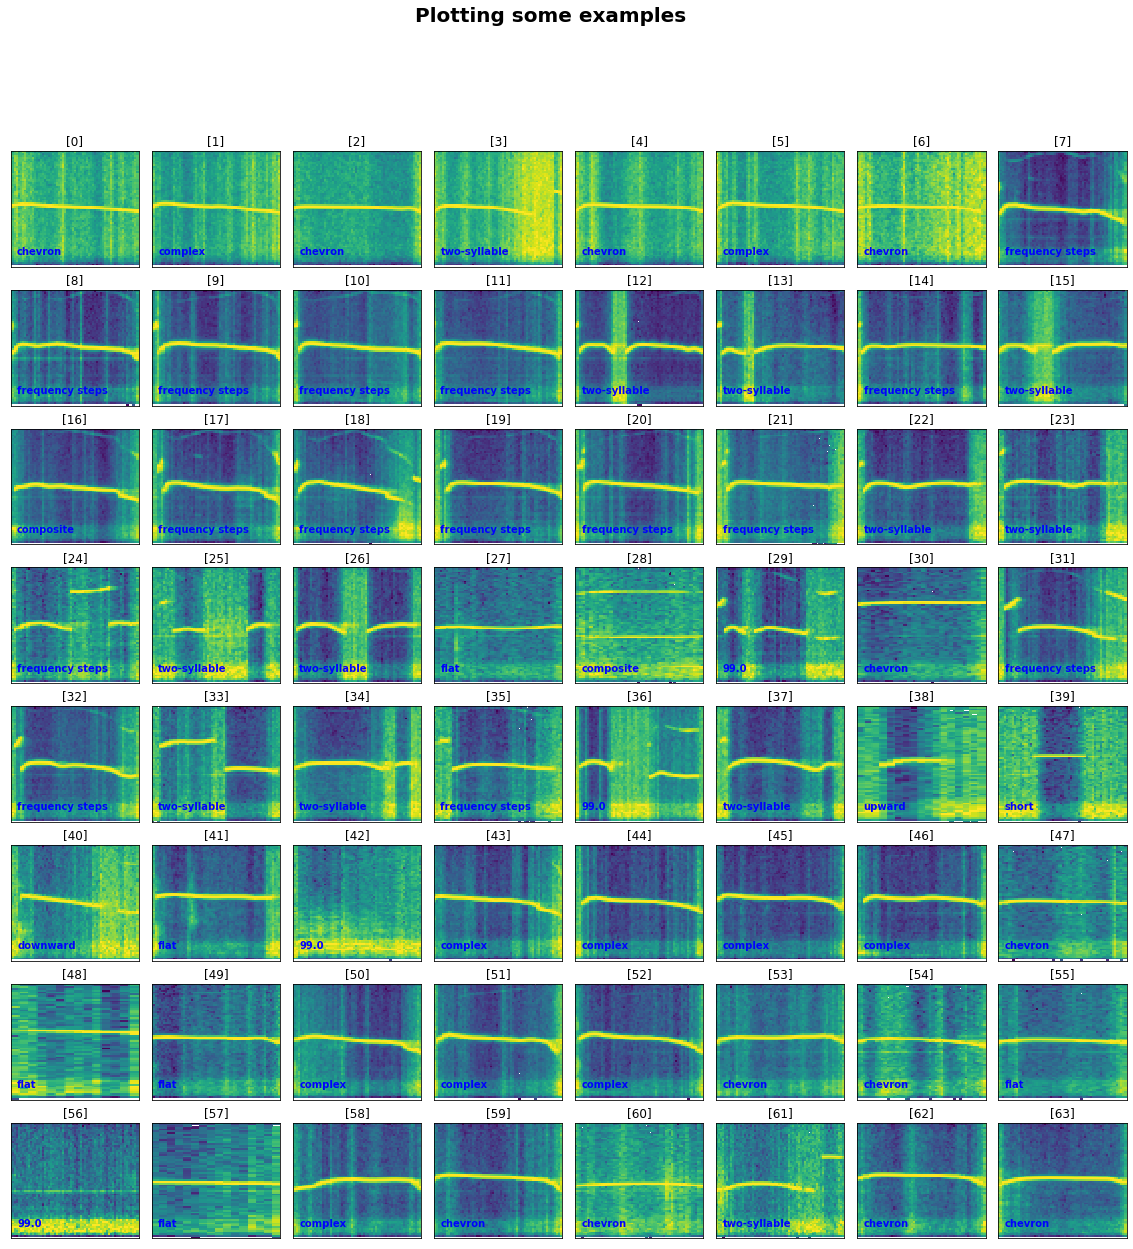

In [100]:
# %matplotlib qt5
img_rows, img_cols = 64, 64 #choosing resize values
Data_united = np.load('Data_united.npy',allow_pickle = True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data_united = np.array([scaler.fit_transform(i) for i in Data_united])

Labels_united = np.load('Labels_united.npy',allow_pickle = True)

Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
upward_syl = Take_Syllables('upward',Data_united,Labels_united)
flat_syl = Take_Syllables('flat',Data_united,Labels_united)
short_syl = Take_Syllables('short',Data_united,Labels_united)
harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)
downward_syl = Take_Syllables('downward',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Noise_syl)))

model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
plot_model(model)


#trying united syllables
freq_two = np.concatenate((Frequency_steps_syl,two_syllable_syl))
complex_chevron_flat = np.concatenate((Chevron_syl,Complex_syl,flat_syl))

freq_two_Labels = np.zeros((len(freq_two)))
complex_chevron_flat_Labels = np.ones((len(complex_chevron_flat)))
#plotting some examples
plot_multiple_imgs(Data_united,Labels_united,8,8,figsize = (20,20),skip = 500,title = 'Plotting some examples')


In [101]:
q,w = np.unique(Labels_united,return_counts = True)
df = pd.DataFrame({'h':q,'j':w})
df = df.sort_values('j')
df

h     j
4          downward    90
8             short   156
7         harmonics   161
5              flat   239
10           upward   394
9      two-syllable   467
0              99.0   613
3         composite   644
2           complex   805
1           chevron   860
6   frequency steps  1462

# **Complex vs Freq**

In [102]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 556, 1042]))
(array([0., 1.]), array([123, 205]))
(array([0., 1.]), array([126, 215]))
Train on 1598 samples, validate on 328 samples
Epoch 1/200
1598/1598 [==============================] - 2s 1ms/step - loss: 0.3839 - accuracy: 0.8329 - val_loss: 0.2307 - val_accuracy: 0.9268
Epoch 2/200
1598/1598 [==============================] - 1s 809us/step - loss: 0.1740 - accuracy: 0.9468 - val_loss: 0.1749 - val_accuracy: 0.9512
Epoch 3/200
1598/1598 [==============================] - 1s 804us/step - loss: 0.1386 - accuracy: 0.9493 - val_loss: 0.1582 - val_accuracy: 0.9543
Epoch 4/200
1598/1598 [==============================] - 1s 806us/step - loss: 0.1185 - accuracy: 0.9637 - val_loss: 0.1480 - val_accuracy: 0.9634
Epoch 5/200
1598/1598 [==============================] - 1s 795us/step - loss: 0.0927 - accuracy: 0.9712 - val_loss: 0.1320 - val_accuracy: 0.9726
Epoch 6/200
1598/1598 [==============================] - 1s 803us/step - loss: 0.0769 - accuracy: 0.9743 - 

(array([0, 1]), array([124, 217]))


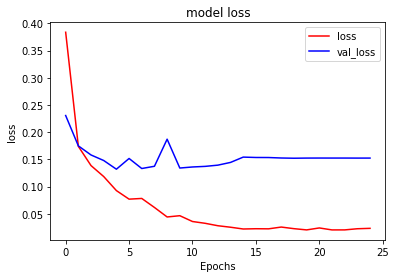

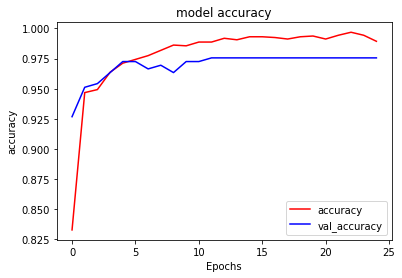

In [103]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


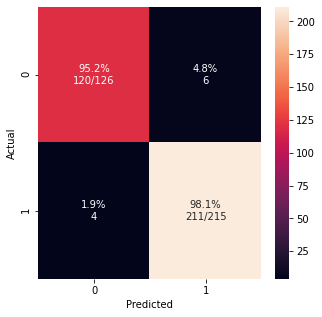

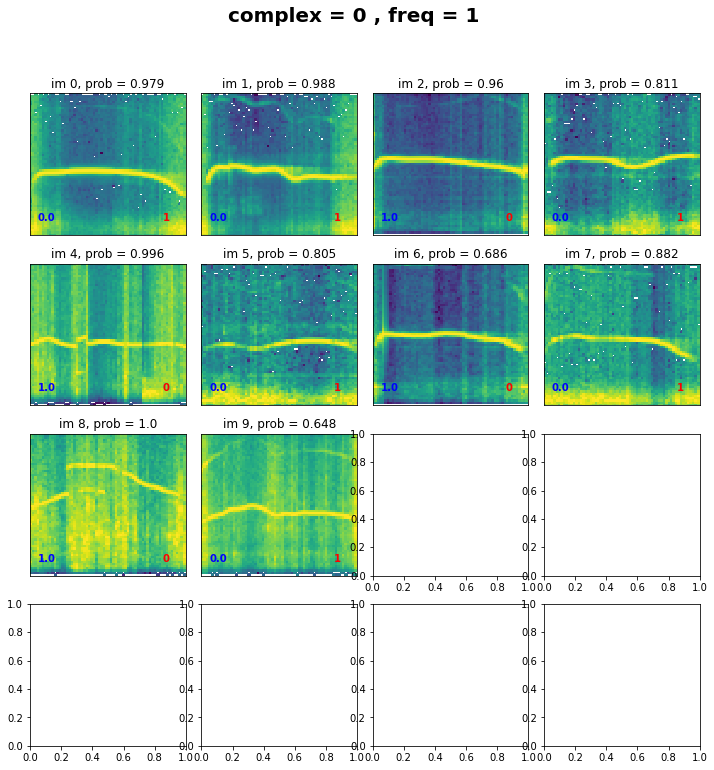

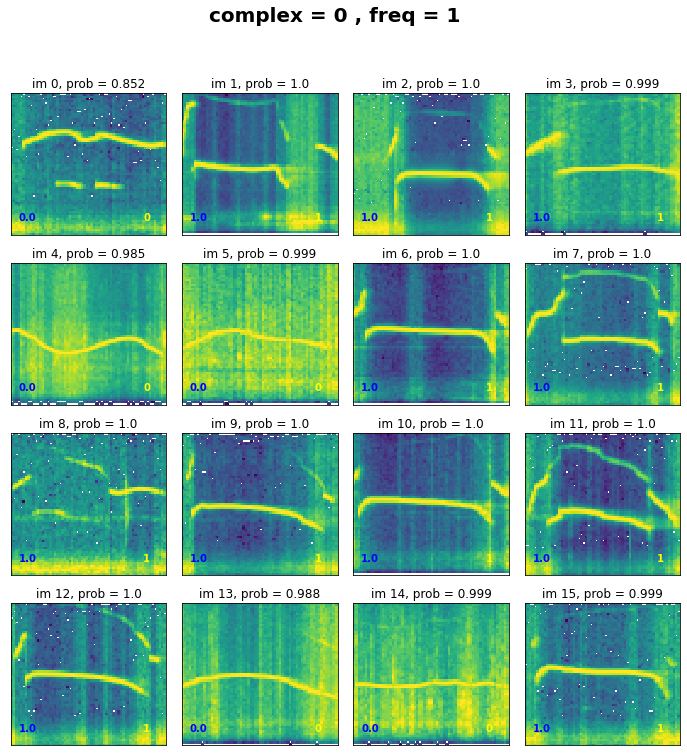

In [104]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'complex = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Complex vs Freq with data augmentation**

---



In [105]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 556, 1042]))
(array([0., 1.]), array([123, 205]))
(array([0., 1.]), array([126, 215]))
Epoch 1/200
13/12 [===============================] - 2s 146ms/step - loss: 0.4110 - accuracy: 0.8085 - val_loss: 0.2579 - val_accuracy: 0.9329
Epoch 2/200
13/12 [===============================] - 1s 103ms/step - loss: 0.1884 - accuracy: 0.9393 - val_loss: 0.1827 - val_accuracy: 0.9573
Epoch 3/200
13/12 [===============================] - 1s 102ms/step - loss: 0.1415 - accuracy: 0.9568 - val_loss: 0.1552 - val_accuracy: 0.9695
Epoch 4/200
13/12 [===============================] - 1s 103ms/step - loss: 0.1148 - accuracy: 0.9618 - val_loss: 0.1520 - val_accuracy: 0.9665
Epoch 5/200
13/12 [===============================] - 1s 103ms/step - loss: 0.1125 - accuracy: 0.9656 - val_loss: 0.1258 - val_accuracy: 0.9695
Epoch 6/200
13/12 [===============================] - 1s 102ms/step - loss: 0.0962 - accuracy: 0.9706 - val_loss: 0.1432 - val_accuracy: 0.9665
Epoch 7/200
13/12 [====

(array([0, 1]), array([124, 217]))


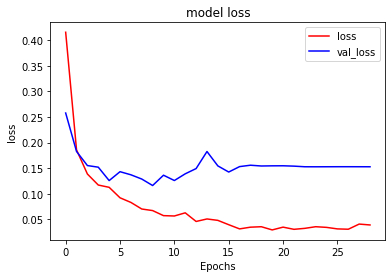

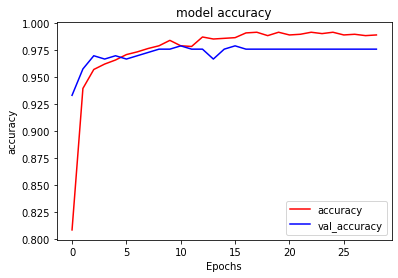

In [106]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


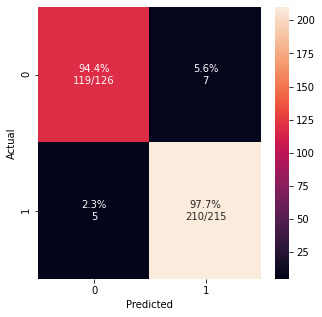

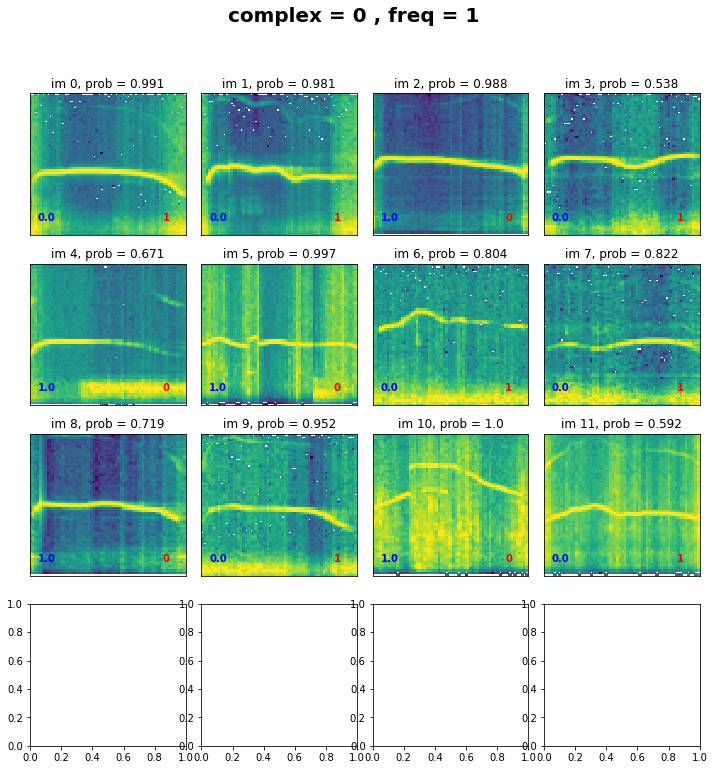

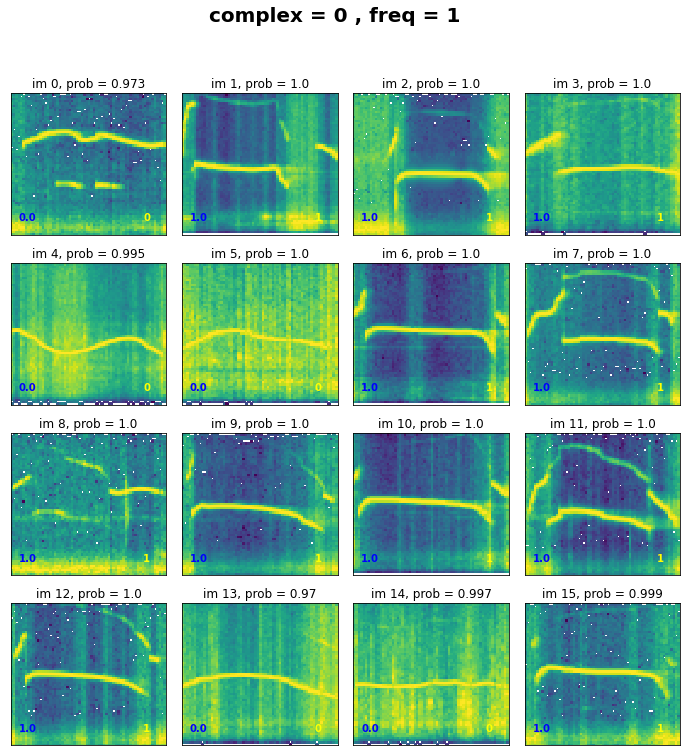

In [107]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'complex = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Complex_Chevron_Flat Vs Frequency_Two syll**

In [108]:
complex_chevron_flat = np.concatenate((Chevron_syl,Complex_syl,flat_syl))
freq_two = np.concatenate((Frequency_steps_syl,two_syllable_syl))

complex_chevron_flat_Labels = np.zeros((len(complex_chevron_flat)))
freq_two_Labels = np.ones((len(freq_two)))


In [109]:
x = np.concatenate((freq_two,complex_chevron_flat))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((freq_two_Labels,complex_chevron_flat_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([1369, 1335]))
(array([0., 1.]), array([275, 279]))
(array([0., 1.]), array([260, 315]))
Train on 2704 samples, validate on 554 samples
Epoch 1/200
2704/2704 [==============================] - 3s 927us/step - loss: 0.3577 - accuracy: 0.8543 - val_loss: 0.2117 - val_accuracy: 0.9386
Epoch 2/200
2704/2704 [==============================] - 2s 808us/step - loss: 0.2096 - accuracy: 0.9249 - val_loss: 0.1826 - val_accuracy: 0.9495
Epoch 3/200
2704/2704 [==============================] - 2s 804us/step - loss: 0.1797 - accuracy: 0.9353 - val_loss: 0.1763 - val_accuracy: 0.9350
Epoch 4/200
2704/2704 [==============================] - 2s 805us/step - loss: 0.1608 - accuracy: 0.9434 - val_loss: 0.1418 - val_accuracy: 0.9549
Epoch 5/200
2704/2704 [==============================] - 2s 808us/step - loss: 0.1475 - accuracy: 0.9490 - val_loss: 0.1499 - val_accuracy: 0.9603
Epoch 6/200
2704/2704 [==============================] - 2s 799us/step - loss: 0.1319 - accuracy: 0.9508 

(array([0, 1]), array([272, 303]))


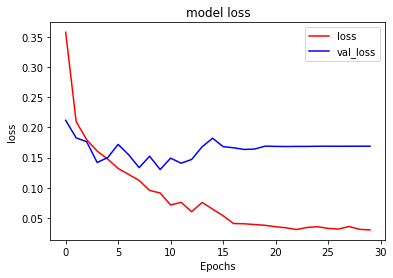

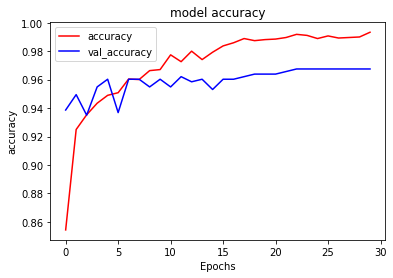

In [110]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


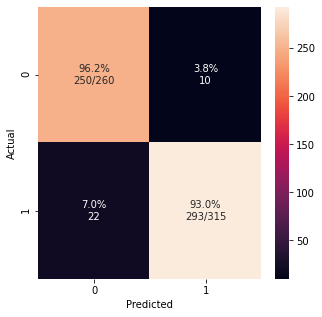

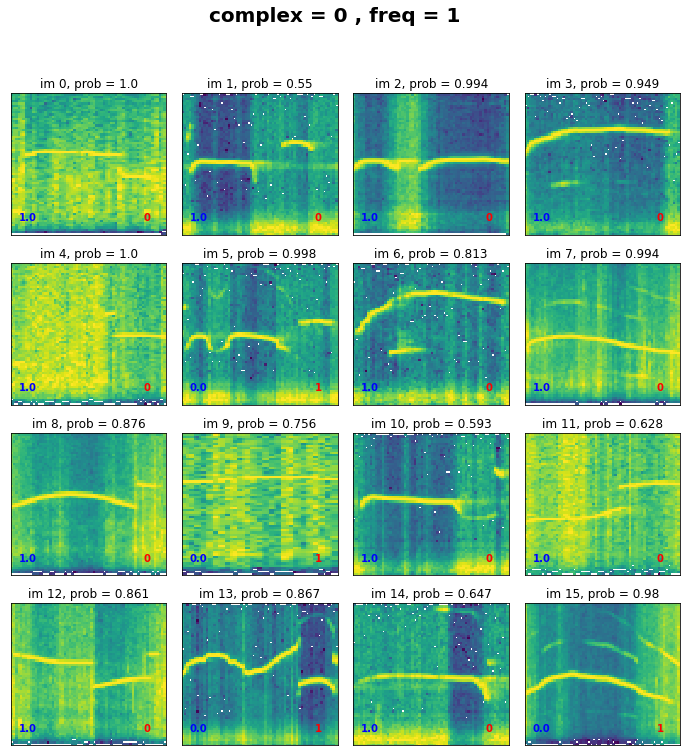

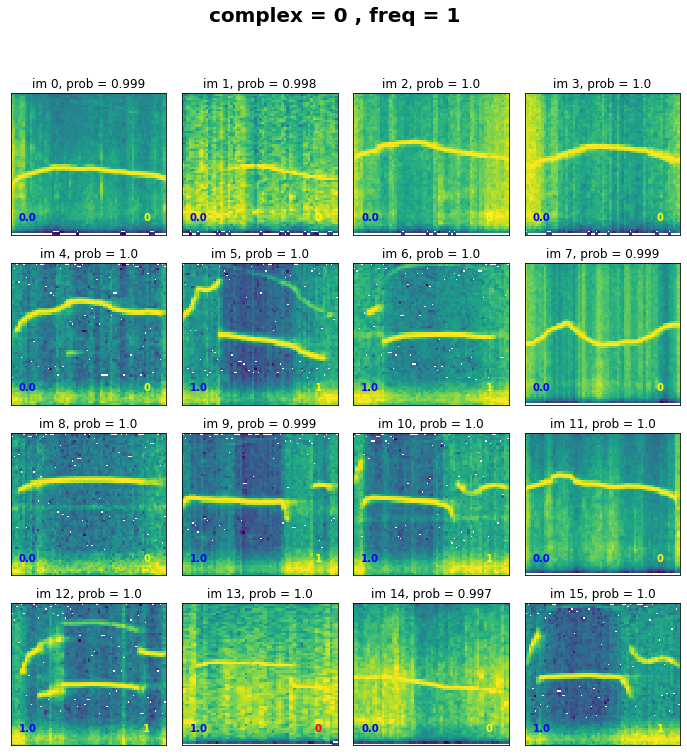

In [111]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'complex = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Complex_Chevron_Flat Vs Frequency_Two syll with data augmentation**

---



---



In [112]:
x = np.concatenate((freq_two,complex_chevron_flat))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((freq_two_Labels,complex_chevron_flat_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([1369, 1335]))
(array([0., 1.]), array([275, 279]))
(array([0., 1.]), array([260, 315]))
Epoch 1/200
22/21 [===============================] - 3s 135ms/step - loss: 0.3668 - accuracy: 0.8317 - val_loss: 0.2351 - val_accuracy: 0.9242
Epoch 2/200
22/21 [===============================] - 2s 103ms/step - loss: 0.2654 - accuracy: 0.9016 - val_loss: 0.2036 - val_accuracy: 0.9368
Epoch 3/200
22/21 [===============================] - 2s 102ms/step - loss: 0.1897 - accuracy: 0.9305 - val_loss: 0.1768 - val_accuracy: 0.9567
Epoch 4/200
22/21 [===============================] - 2s 103ms/step - loss: 0.1807 - accuracy: 0.9379 - val_loss: 0.1443 - val_accuracy: 0.9549
Epoch 5/200
22/21 [===============================] - 2s 103ms/step - loss: 0.1508 - accuracy: 0.9482 - val_loss: 0.1354 - val_accuracy: 0.9621
Epoch 6/200
22/21 [===============================] - 2s 113ms/step - loss: 0.1496 - accuracy: 0.9467 - val_loss: 0.1453 - val_accuracy: 0.9513
Epoch 7/200
22/21 [====

(array([0, 1]), array([268, 307]))


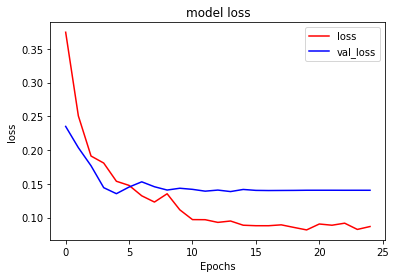

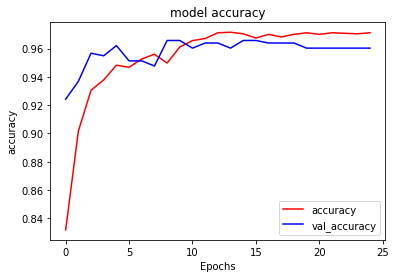

In [113]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


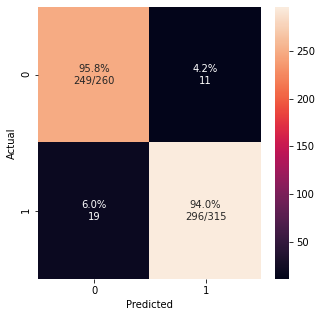

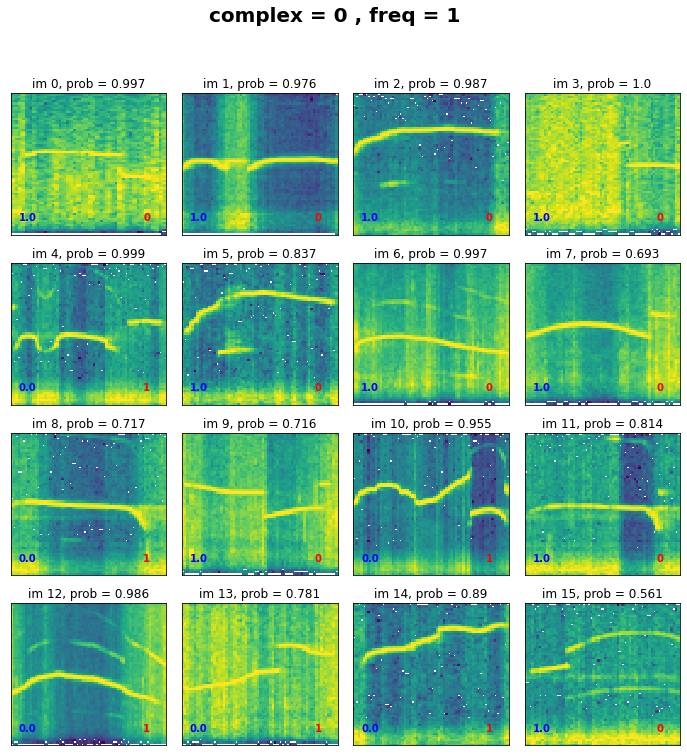

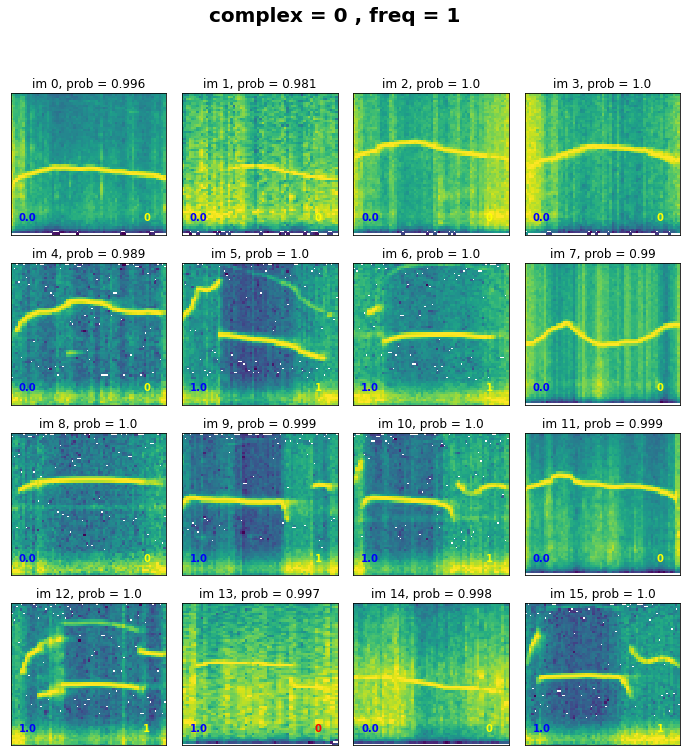

In [114]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'complex = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Freq Vs Chevron**

In [115]:
Chevron_Labels = np.zeros((len(Chevron_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
x = np.concatenate((Chevron_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((Chevron_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 617, 1020]))
(array([0., 1.]), array([108, 228]))
(array([0., 1.]), array([135, 214]))
Train on 1637 samples, validate on 336 samples
Epoch 1/200
1637/1637 [==============================] - 2s 1ms/step - loss: 0.4004 - accuracy: 0.7911 - val_loss: 0.2100 - val_accuracy: 0.9345
Epoch 2/200
1637/1637 [==============================] - 1s 800us/step - loss: 0.1985 - accuracy: 0.9273 - val_loss: 0.1760 - val_accuracy: 0.9375
Epoch 3/200
1637/1637 [==============================] - 1s 805us/step - loss: 0.1447 - accuracy: 0.9493 - val_loss: 0.1594 - val_accuracy: 0.9405
Epoch 4/200
1637/1637 [==============================] - 1s 804us/step - loss: 0.1331 - accuracy: 0.9524 - val_loss: 0.1386 - val_accuracy: 0.9464
Epoch 5/200
1637/1637 [==============================] - 1s 800us/step - loss: 0.1150 - accuracy: 0.9591 - val_loss: 0.1282 - val_accuracy: 0.9494
Epoch 6/200
1637/1637 [==============================] - 1s 806us/step - loss: 0.0858 - accuracy: 0.9695 - 

(array([0, 1]), array([138, 211]))


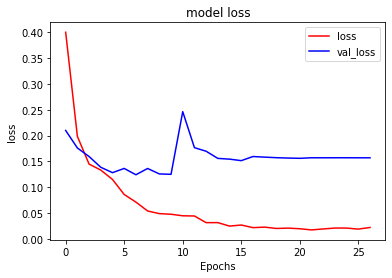

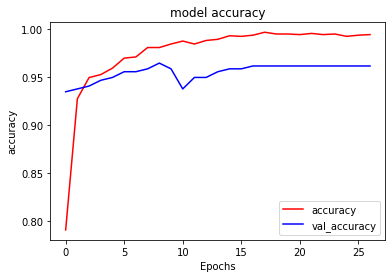

In [116]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


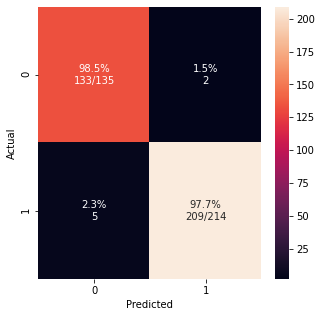

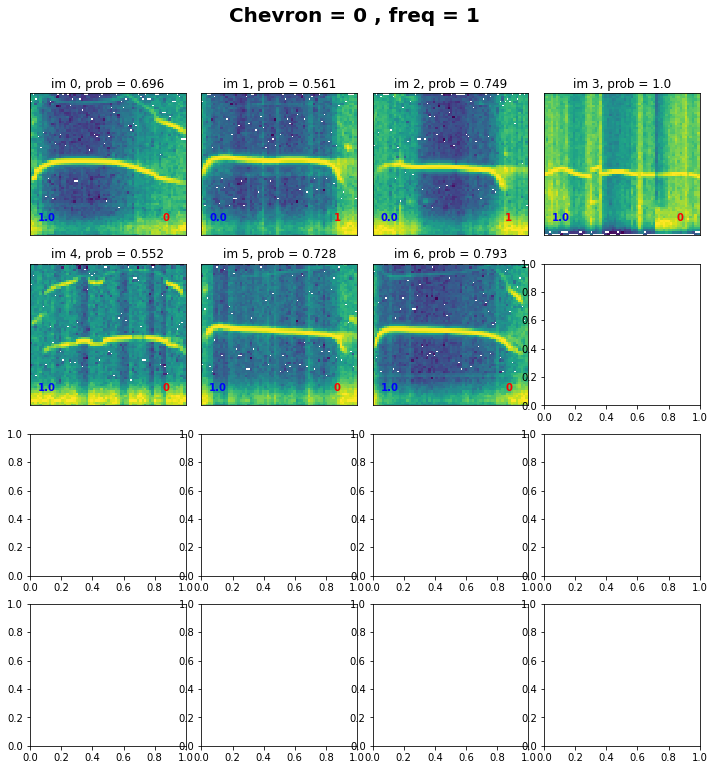

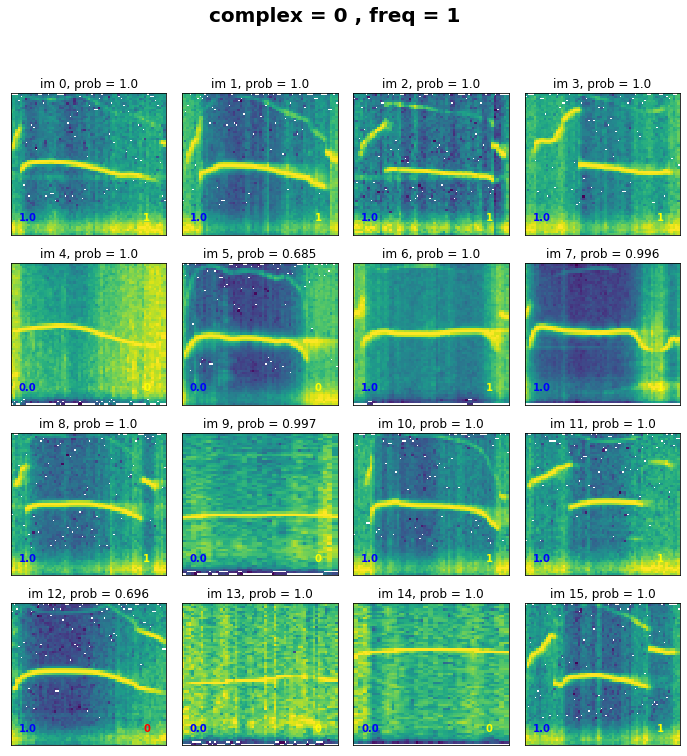

In [117]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'Chevron = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Freq Vs Chevron with data augmentation**

---



In [118]:
Chevron_Labels = np.zeros((len(Chevron_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
x = np.concatenate((Chevron_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((Chevron_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 617, 1020]))
(array([0., 1.]), array([108, 228]))
(array([0., 1.]), array([135, 214]))
Epoch 1/200
13/12 [==============================] - 2s 164ms/step - loss: 0.3880 - accuracy: 0.7850 - val_loss: 0.2030 - val_accuracy: 0.9435
Epoch 2/200
13/12 [==============================] - 1s 103ms/step - loss: 0.1827 - accuracy: 0.9334 - val_loss: 0.1623 - val_accuracy: 0.9405
Epoch 3/200
13/12 [==============================] - 1s 105ms/step - loss: 0.1423 - accuracy: 0.9542 - val_loss: 0.1191 - val_accuracy: 0.9643
Epoch 4/200
13/12 [==============================] - 1s 104ms/step - loss: 0.1160 - accuracy: 0.9566 - val_loss: 0.1163 - val_accuracy: 0.9613
Epoch 5/200
13/12 [==============================] - 1s 104ms/step - loss: 0.1036 - accuracy: 0.9591 - val_loss: 0.1095 - val_accuracy: 0.9643
Epoch 6/200
13/12 [==============================] - 1s 104ms/step - loss: 0.0978 - accuracy: 0.9676 - val_loss: 0.1426 - val_accuracy: 0.9464
Epoch 7/200
13/12 [==========

(array([0, 1]), array([137, 212]))


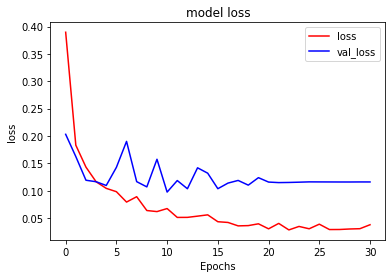

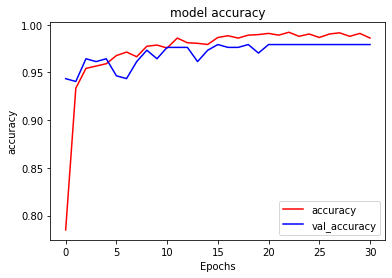

In [119]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


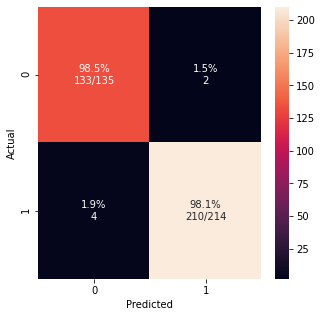

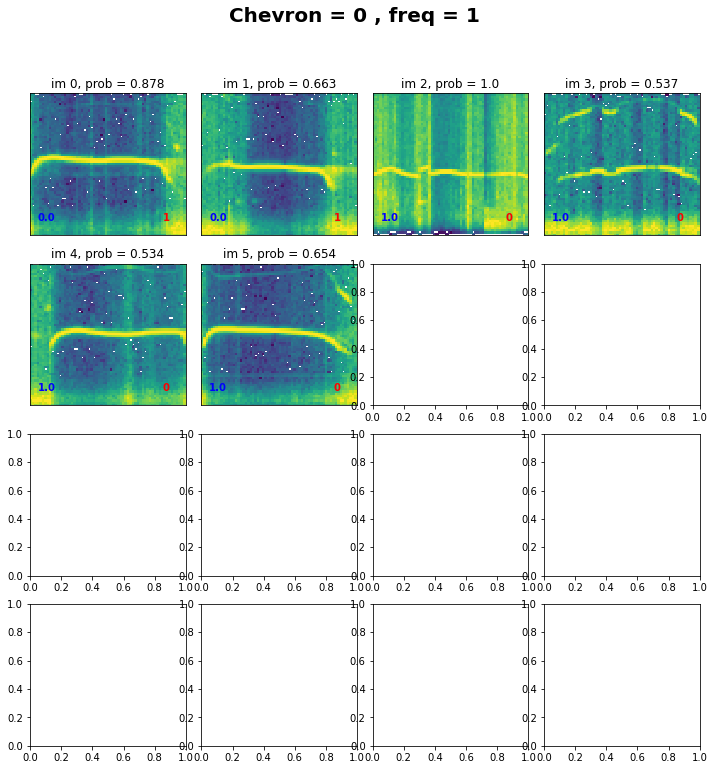

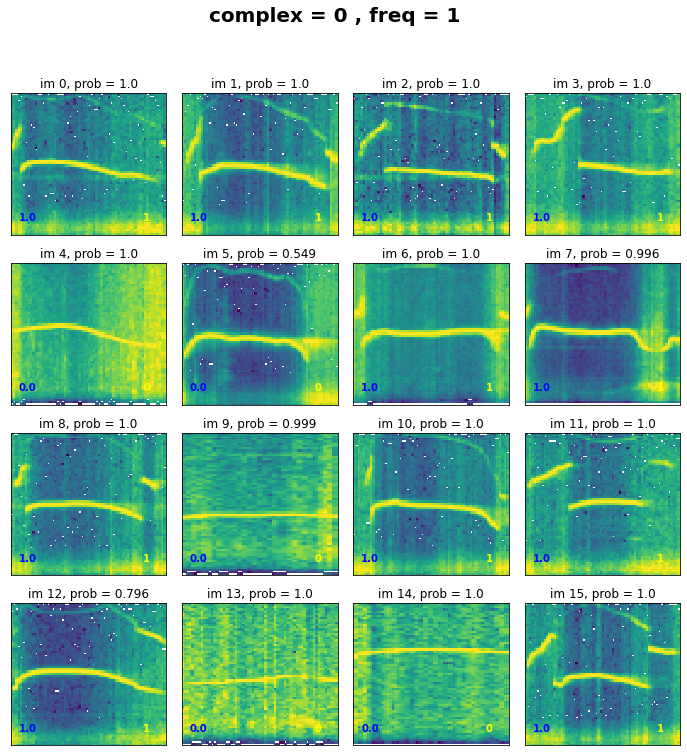

In [120]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'Chevron = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Freq Vs complex vs composite**


In [121]:
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
# Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
# Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
# two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
# flat_syl = Take_Syllables('flat',Data_united,Labels_united)
# harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
# Noise_Labels = 3*np.ones((len(Composite_syl)))

In [122]:
x = np.concatenate((Complex_syl,Frequency_steps_syl,Composite_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels,composite_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=3)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1., 2.]), array([ 566, 1032,  455]))
(array([0., 1., 2.]), array([115, 206, 100]))
(array([0., 1., 2.]), array([124, 224,  89]))
Train on 2053 samples, validate on 421 samples
Epoch 1/200
2053/2053 [==============================] - 2s 1ms/step - loss: 0.6487 - accuracy: 0.7175 - val_loss: 0.3809 - val_accuracy: 0.8836
Epoch 2/200
2053/2053 [==============================] - 2s 806us/step - loss: 0.3527 - accuracy: 0.8841 - val_loss: 0.3413 - val_accuracy: 0.8979
Epoch 3/200
2053/2053 [==============================] - 2s 809us/step - loss: 0.3018 - accuracy: 0.9040 - val_loss: 0.3000 - val_accuracy: 0.9074
Epoch 4/200
2053/2053 [==============================] - 2s 812us/step - loss: 0.2538 - accuracy: 0.9172 - val_loss: 0.2898 - val_accuracy: 0.9097
Epoch 5/200
2053/2053 [==============================] - 2s 808us/step - loss: 0.2266 - accuracy: 0.9260 - val_loss: 0.3272 - val_accuracy: 0.8907
Epoch 6/200
2053/2053 [==============================] - 2s 803us/step - loss: 

(array([0, 1, 2]), array([123, 226,  88]))


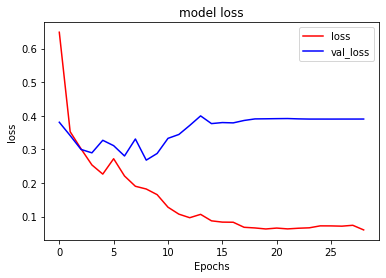

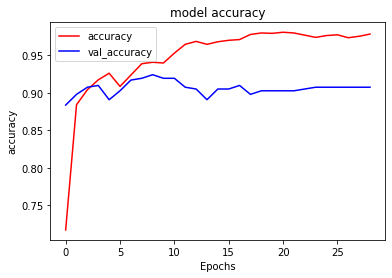

In [123]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


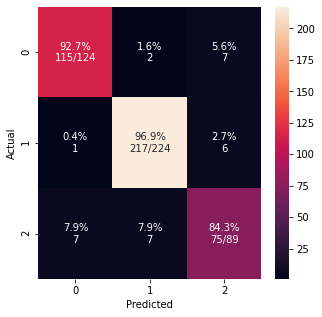

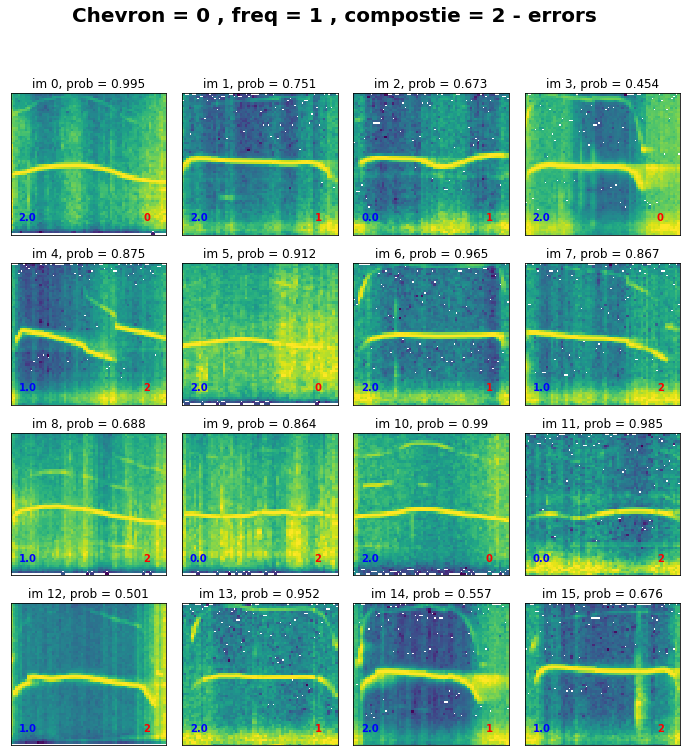

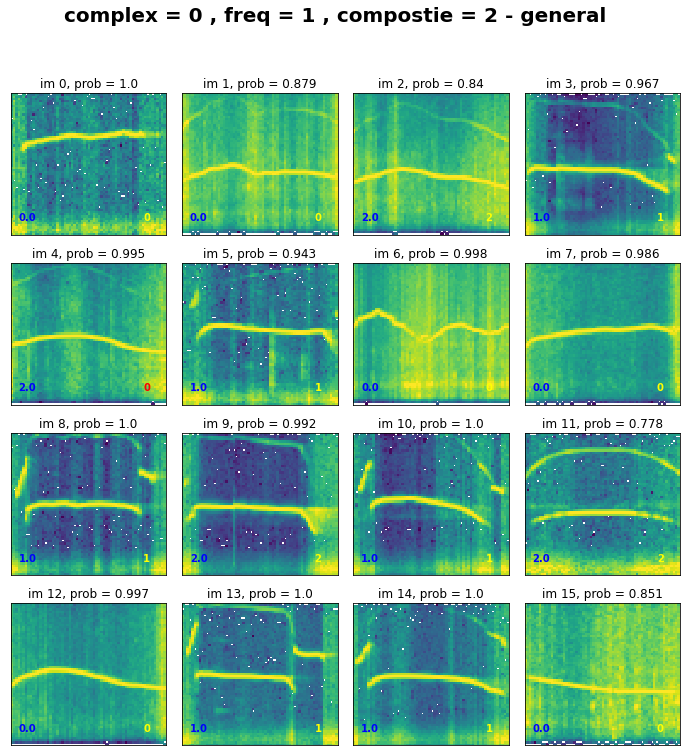

In [124]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1,2])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'Chevron = 0 , freq = 1 , compostie = 2 - errors',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1 , compostie = 2 - general',prob = predictions)


# **Freq Vs complex vs composite with data augmentation**


In [125]:
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
# Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
# Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
# two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
# flat_syl = Take_Syllables('flat',Data_united,Labels_united)
# harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
# Noise_Labels = 3*np.ones((len(Composite_syl)))

In [126]:
x = np.concatenate((Complex_syl,Frequency_steps_syl,Composite_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels,composite_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=3)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1., 2.]), array([ 566, 1032,  455]))
(array([0., 1., 2.]), array([115, 206, 100]))
(array([0., 1., 2.]), array([124, 224,  89]))
Epoch 1/200
17/16 [===============================] - 2s 140ms/step - loss: 0.7082 - accuracy: 0.6897 - val_loss: 0.3875 - val_accuracy: 0.8741
Epoch 2/200
17/16 [===============================] - 2s 101ms/step - loss: 0.3951 - accuracy: 0.8568 - val_loss: 0.3644 - val_accuracy: 0.8907
Epoch 3/200
17/16 [===============================] - 2s 102ms/step - loss: 0.3127 - accuracy: 0.8914 - val_loss: 0.3536 - val_accuracy: 0.9002
Epoch 4/200
17/16 [===============================] - 2s 102ms/step - loss: 0.2827 - accuracy: 0.8967 - val_loss: 0.3124 - val_accuracy: 0.9121
Epoch 5/200
17/16 [===============================] - 2s 101ms/step - loss: 0.2662 - accuracy: 0.9099 - val_loss: 0.3098 - val_accuracy: 0.9169
Epoch 6/200
17/16 [===============================] - 2s 103ms/step - loss: 0.2338 - accuracy: 0.9196 - val_loss: 0.3026 - val_accuracy: 0.

(array([0, 1, 2]), array([119, 226,  92]))


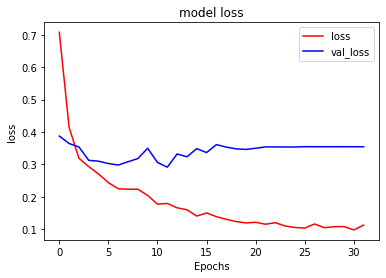

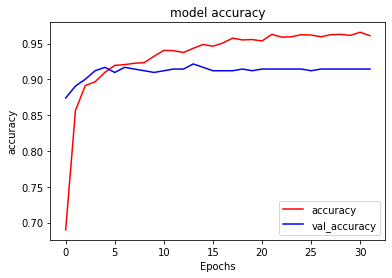

In [127]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


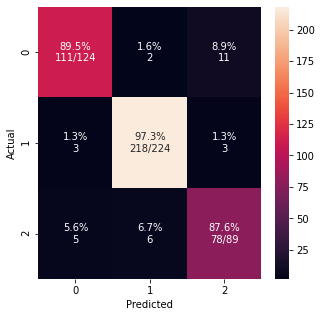

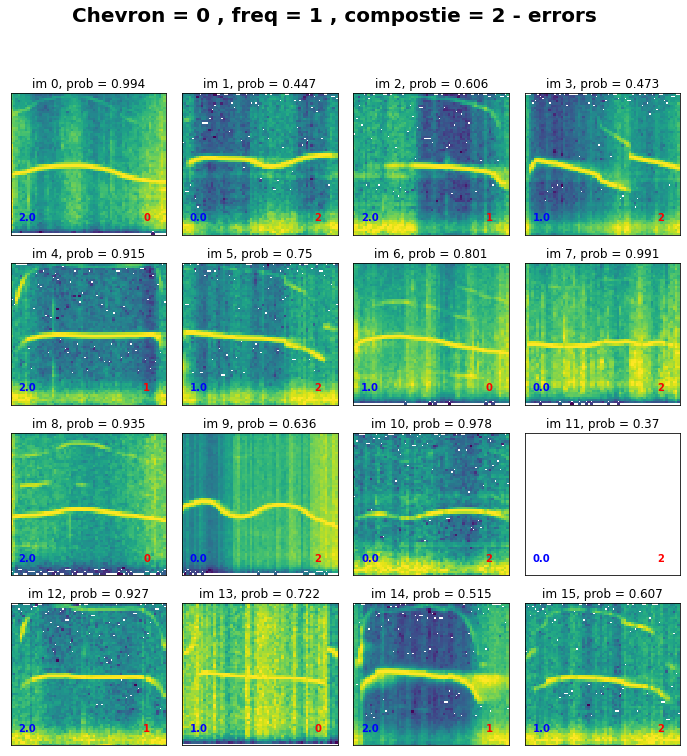

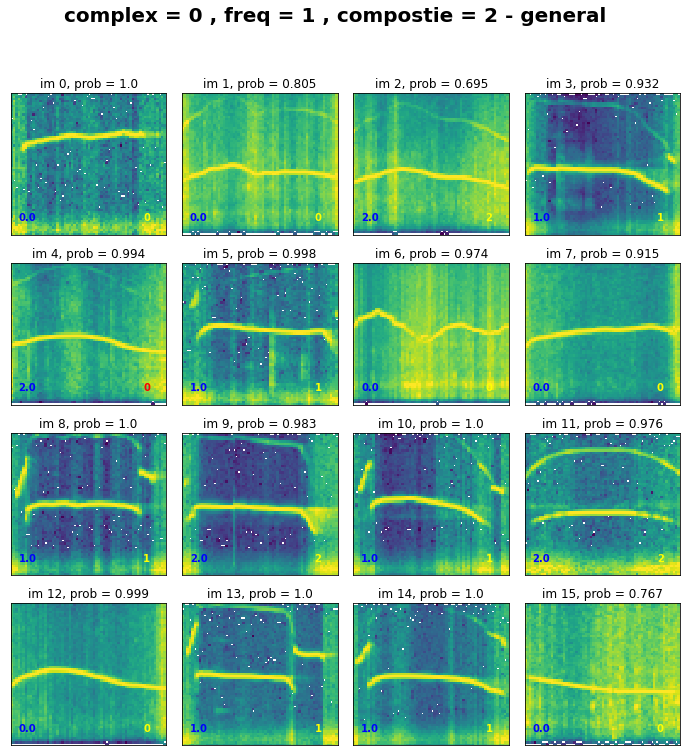

In [128]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1,2])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'Chevron = 0 , freq = 1 , compostie = 2 - errors',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1 , compostie = 2 - general',prob = predictions)


# **Freq Vs complex vs composite vs noise**


In [129]:
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
# Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
# two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
# flat_syl = Take_Syllables('flat',Data_united,Labels_united)
# harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Noise_syl)))

In [130]:
x = np.concatenate((Complex_syl,Frequency_steps_syl,Composite_syl,Noise_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels,composite_Labels,Noise_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=4)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1., 2., 3.]), array([ 552, 1051,  457,  425]))
(array([0., 1., 2., 3.]), array([110, 207,  94,  99]))
(array([0., 1., 2., 3.]), array([143, 204,  93,  89]))
Train on 2485 samples, validate on 510 samples
Epoch 1/200
2485/2485 [==============================] - 3s 1ms/step - loss: 0.7860 - accuracy: 0.7054 - val_loss: 0.5241 - val_accuracy: 0.8216
Epoch 2/200
2485/2485 [==============================] - 2s 810us/step - loss: 0.5203 - accuracy: 0.8205 - val_loss: 0.4443 - val_accuracy: 0.8412
Epoch 3/200
2485/2485 [==============================] - 2s 808us/step - loss: 0.4471 - accuracy: 0.8499 - val_loss: 0.4228 - val_accuracy: 0.8490
Epoch 4/200
2485/2485 [==============================] - 2s 806us/step - loss: 0.4106 - accuracy: 0.8600 - val_loss: 0.3967 - val_accuracy: 0.8627
Epoch 5/200
2485/2485 [==============================] - 2s 805us/step - loss: 0.3822 - accuracy: 0.8708 - val_loss: 0.3928 - val_accuracy: 0.8608
Epoch 6/200
2485/2485 [============================

(array([0, 1, 2, 3]), array([141, 214,  94,  80]))


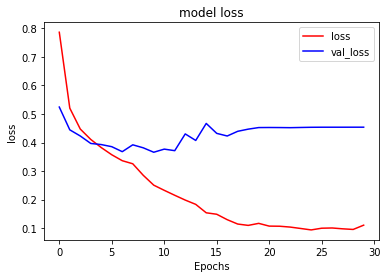

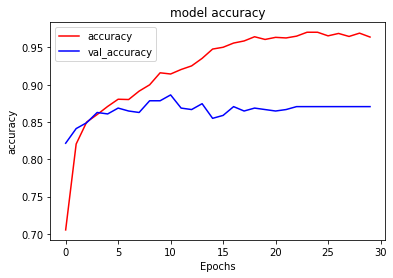

In [131]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


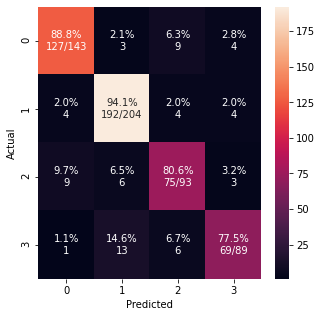

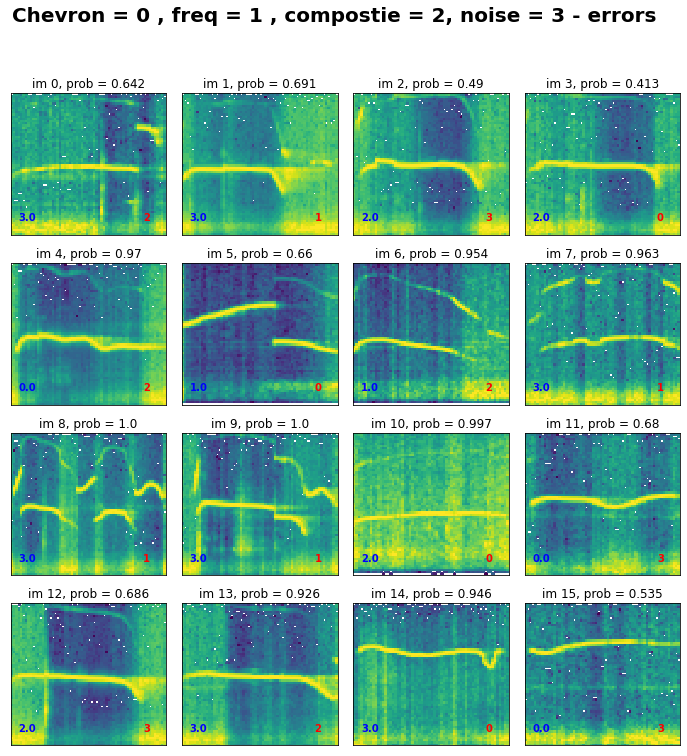

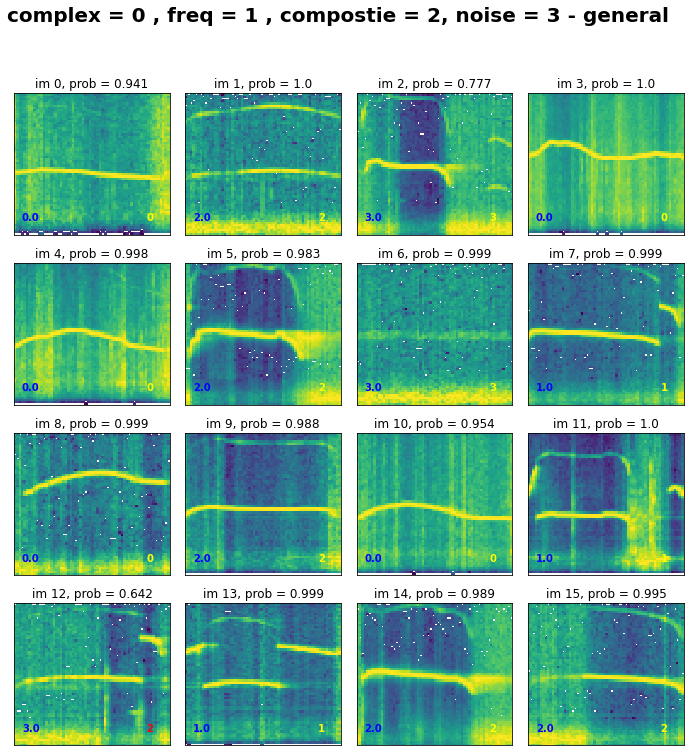

In [132]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1,2,3])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'Chevron = 0 , freq = 1 , compostie = 2, noise = 3 - errors',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1 , compostie = 2, noise = 3 - general',prob = predictions)


# **Freq Vs complex vs composite vs noise with data augmentation**


In [133]:
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
# Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
# two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
# flat_syl = Take_Syllables('flat',Data_united,Labels_united)
# harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Noise_syl)))

In [134]:
x = np.concatenate((Complex_syl,Frequency_steps_syl,Composite_syl,Noise_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels,composite_Labels,Noise_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=4)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1., 2., 3.]), array([ 552, 1051,  457,  425]))
(array([0., 1., 2., 3.]), array([110, 207,  94,  99]))
(array([0., 1., 2., 3.]), array([143, 204,  93,  89]))
Epoch 1/200
20/19 [==============================] - 3s 136ms/step - loss: 0.8425 - accuracy: 0.6905 - val_loss: 0.5378 - val_accuracy: 0.8490
Epoch 2/200
20/19 [==============================] - 2s 105ms/step - loss: 0.5453 - accuracy: 0.8145 - val_loss: 0.4733 - val_accuracy: 0.8451
Epoch 3/200
20/19 [==============================] - 2s 104ms/step - loss: 0.4856 - accuracy: 0.8366 - val_loss: 0.4581 - val_accuracy: 0.8490
Epoch 4/200
20/19 [==============================] - 2s 104ms/step - loss: 0.4441 - accuracy: 0.8507 - val_loss: 0.4129 - val_accuracy: 0.8647
Epoch 5/200
20/19 [==============================] - 2s 104ms/step - loss: 0.4126 - accuracy: 0.8596 - val_loss: 0.3901 - val_accuracy: 0.8725
Epoch 6/200
20/19 [==============================] - 2s 104ms/step - loss: 0.3750 - accuracy: 0.8728 - val_loss: 0.3

(array([0, 1, 2, 3]), array([142, 220,  91,  76]))


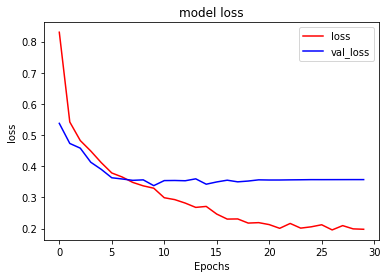

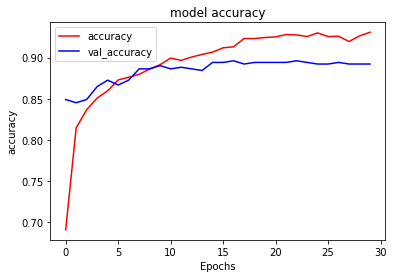

In [135]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10


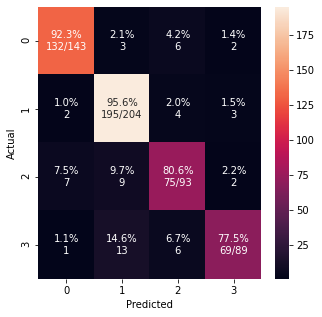

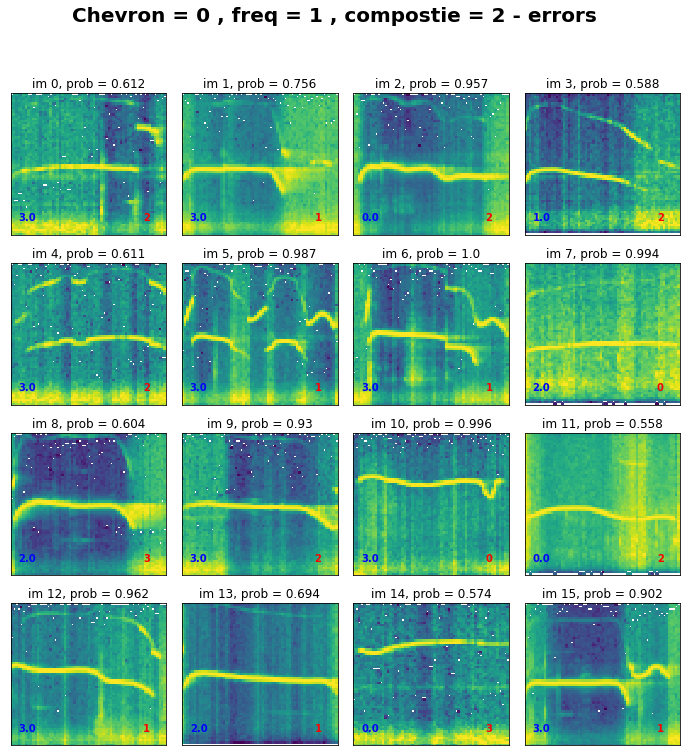

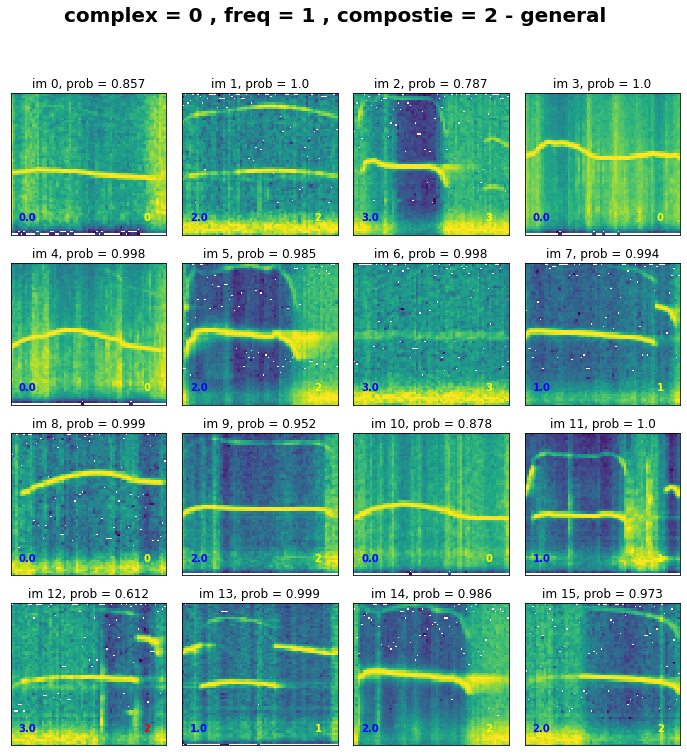

In [137]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1,2,3])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'Chevron = 0 , freq = 1 , compostie = 2 - errors',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1 , compostie = 2 - general',prob = predictions)
